# Arabic Sentiment Analysis: BiLSTM vs. AraBERT Comparison

**Author:** Belal  
**Date:** January 2026  
**Project:** Comparative study of deep learning approaches for Arabic sentiment analysis

## Overview
This notebook implements and compares two approaches for Arabic sentiment analysis:
1. **BiLSTM** - Custom bidirectional LSTM with word embeddings
2. **AraBERT** - Fine-tuned transformer model (transfer learning)

## Key Features
- Advanced Arabic text preprocessing (normalization, diacritics removal)
- Bidirectional LSTM architecture with dropout regularization
- Transfer learning with state-of-the-art AraBERT
- Comprehensive evaluation metrics and visualizations
- Model comparison and inference demo

## Dataset
**Expected Format:** CSV file with columns `text` and `Sentiment` (0=negative, 1=positive)  
**Source:** Place your dataset as `arabic_sentiment_data.csv` in the working directory

---

## 1. Environment Setup & Package Installation

In [18]:
# Environment Configuration
import os
import sys

# Configure TensorFlow for CPU (remove if you have GPU)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Install required packages (uncomment if needed)
# !pip install -q tensorflow scikit-learn transformers datasets torch matplotlib seaborn arabic-reshaper python-bidi

print("✓ Environment configured")

✓ Environment configured


## 2. Import Libraries

In [19]:
# Core Libraries
import re
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support
)

# Deep Learning (TensorFlow/Keras)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Transfer Learning (Transformers)
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

# Visualization Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 3. Configuration

In [20]:
# Model Configuration
CONFIG = {
    # Data paths
    'data_path': '/kaggle/input/arabic-sentiment-analysis-dataset-ss2030-dataset/Arabic Sentiment Analysis Dataset - SS2030.csv',
    
    # BiLSTM parameters
    'max_words': 5000,
    'max_sequence_length': 100,
    'embedding_dim': 128,
    'lstm_units': [64, 32],
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 10,
    
    # AraBERT parameters
    'arabert_model': 'aubmindlab/bert-base-arabertv02',
    'arabert_max_length': 256,
    'arabert_batch_size': 8,
    'arabert_epochs': 3,
    'arabert_learning_rate': 2e-5,
    
    # General
    'test_size': 0.2,
    'val_size': 0.1,
    'random_seed': 42
}

# Set random seeds for reproducibility
np.random.seed(CONFIG['random_seed'])
torch.manual_seed(CONFIG['random_seed'])

print("✓ Configuration loaded")

✓ Configuration loaded


## 4. Data Loading & Exploration

In [21]:
# Load dataset
print("Loading dataset...")

# Try multiple potential paths
possible_paths = [
    CONFIG['data_path'],
    'data.csv',
    './data.csv',
    '../data.csv'
]

df = None
for path in possible_paths:
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            if {'text', 'Sentiment'}.issubset(df.columns):
                print(f"✓ Dataset loaded from: {path}")
                break
        except Exception as e:
            continue

# Handle missing dataset
if df is None:
    print("\n⚠ WARNING: Dataset not found!")
    print("For demonstration purposes, creating a small sample dataset.")
    print("\n** IMPORTANT: Replace with real data for actual results **\n")
    
    # Create minimal demo data
    demo_data = {
        'text': [
            "هذا المنتج رائع جداً وأنصح به بشدة",
            "تجربة سيئة جداً ولا أنصح بها",
            "خدمة ممتازة وسريعة",
            "منتج رديء الجودة"
        ] * 50,  # Replicate for demo
        'Sentiment': [1, 0, 1, 0] * 50
    }
    df = pd.DataFrame(demo_data)
    print(f"✓ Created demo dataset with {len(df)} samples")

# Basic data info
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
display(df.head())

# Class distribution
print("\nClass Distribution:")
print(df['Sentiment'].value_counts())
print(f"\nClass Balance: {df['Sentiment'].value_counts(normalize=True).to_dict()}")

Loading dataset...
✓ Dataset loaded from: /kaggle/input/arabic-sentiment-analysis-dataset-ss2030-dataset/Arabic Sentiment Analysis Dataset - SS2030.csv

Dataset Shape: (4252, 2)

Columns: ['text', 'Sentiment']

First few rows:


,text,Sentiment
0,حقوق المرأة 💚💚💚 https://t.co/Mzf90Ta5g1,1
1,RT @___IHAVENOIDEA: حقوق المرأة في الإسلام. ht...,1
2,RT @saud_talep: Retweeted لجنة التنمية بشبرا (...,1
3,RT @MojKsa: حقوق المرأة التي تضمنها لها وزارة ...,1
4,RT @abm112211: ولي امر الزوجة او ولي الزوجة او...,1



Class Distribution:
Sentiment
1    2436
0    1816
Name: count, dtype: int64

Class Balance: {1: 0.5729068673565381, 0: 0.4270931326434619}


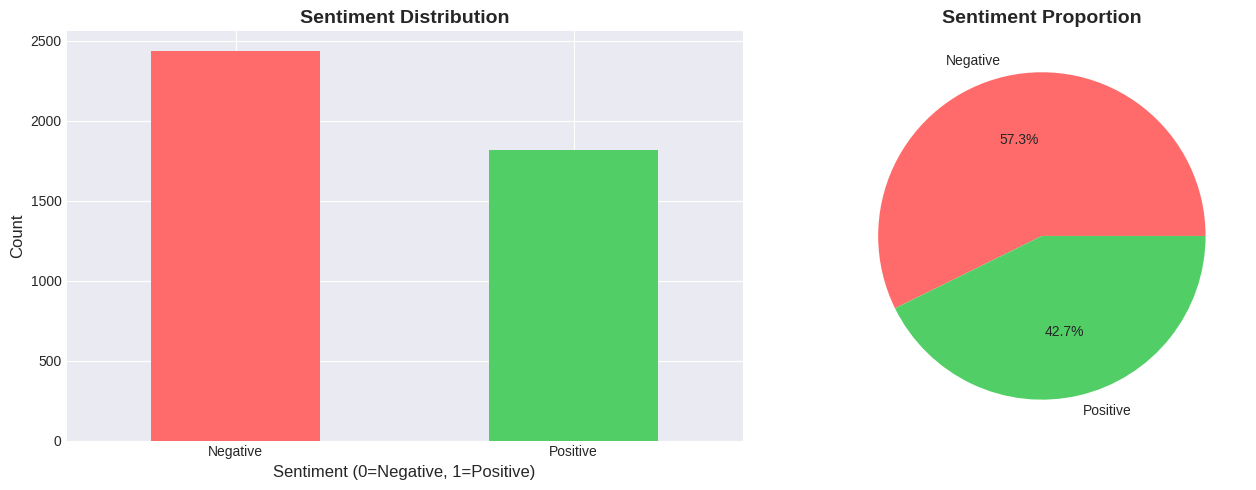

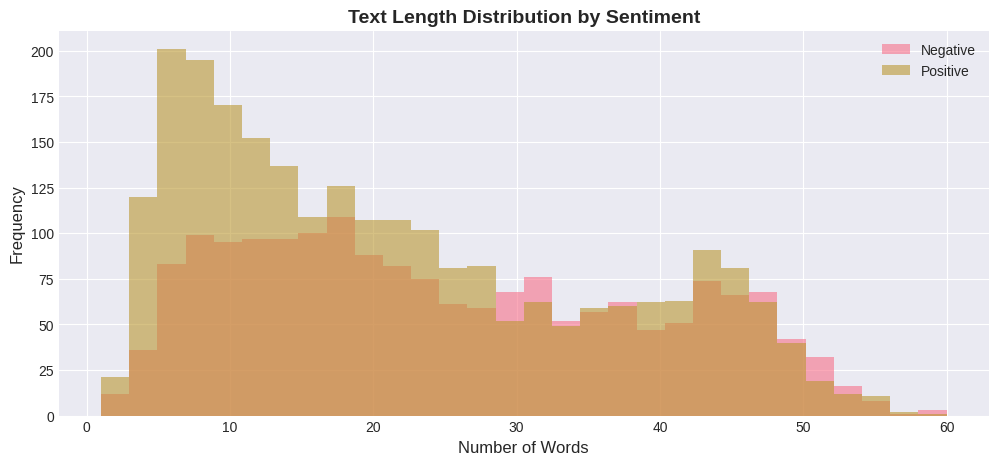

Average text length: 23.2 words
Median text length: 20.0 words


In [22]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
df['Sentiment'].value_counts().plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#51cf66'])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Negative', 'Positive'], rotation=0)

# Pie chart
df['Sentiment'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                     colors=['#ff6b6b', '#51cf66'], labels=['Negative', 'Positive'])
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Text length analysis
df['text_length'] = df['text'].astype(str).apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize=(12, 5))
df.groupby('Sentiment')['text_length'].hist(bins=30, alpha=0.6, ax=ax, label=['Negative', 'Positive'])
ax.set_title('Text Length Distribution by Sentiment', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Words', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(['Negative', 'Positive'])
plt.show()

print(f"Average text length: {df['text_length'].mean():.1f} words")
print(f"Median text length: {df['text_length'].median():.1f} words")

## 5. Text Preprocessing

In [23]:
def clean_arabic_text(text):
    """
    Comprehensive Arabic text preprocessing
    
    Steps:
    1. Remove URLs, mentions, hashtags, RT markers
    2. Keep only Arabic letters and spaces
    3. Normalize Arabic characters (alef, yeh, hamza, teh marbuta)
    4. Remove diacritics (tashkeel)
    5. Normalize whitespace
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Remove URLs, RT, mentions, hashtags
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"\bRT\b", " ", text)
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)
    text = re.sub(r"#", " ", text)
    
    # Keep only Arabic letters
    text = re.sub(r"[^ء-ي\s]", " ", text)
    
    # Normalize Arabic characters
    text = re.sub(r"[إأآا]", "ا", text)  # Normalize alef
    text = re.sub(r"ى", "ي", text)        # Normalize yeh
    text = re.sub(r"ؤ", "ء", text)        # Normalize hamza on waw
    text = re.sub(r"ئ", "ء", text)        # Normalize hamza on yeh
    text = re.sub(r"ة", "ه", text)        # Normalize teh marbuta
    
    # Remove diacritics
    text = re.sub(r"[ًٌٍَُِّْـ]", "", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Apply preprocessing
print("Preprocessing text...")
df['text_clean'] = df['text'].apply(clean_arabic_text)

# Remove very short texts
min_words = 2
initial_count = len(df)
df = df[df['text_clean'].str.split().str.len() >= min_words]
print(f"✓ Removed {initial_count - len(df)} texts with < {min_words} words")

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates(subset=['text_clean'])
print(f"✓ Removed {initial_count - len(df)} duplicate texts")

print(f"\nFinal dataset size: {len(df)} samples")

# Show preprocessing examples
print("\nPreprocessing Examples:")
print("-" * 80)
for i in range(min(3, len(df))):
    print(f"Original:  {df['text'].iloc[i]}")
    print(f"Cleaned:   {df['text_clean'].iloc[i]}")
    print("-" * 80)

Preprocessing text...
✓ Removed 2 texts with < 2 words
✓ Removed 257 duplicate texts

Final dataset size: 3993 samples

Preprocessing Examples:
--------------------------------------------------------------------------------
Original:  حقوق المرأة 💚💚💚 https://t.co/Mzf90Ta5g1
Cleaned:   حقوق المراه
--------------------------------------------------------------------------------
Original:  RT @___IHAVENOIDEA: حقوق المرأة في الإسلام. https://t.co/ps3qNw1CbB
Cleaned:   حقوق المراه في الاسلام
--------------------------------------------------------------------------------
Original:  RT @saud_talep: Retweeted لجنة التنمية بشبرا (@Shubratanmyeh):
 
 ما زال التسجيل مستمر في دورة حقوق المرأة بعد الطلاق ✨ #وعيك_يحميك... https://t.co/c2NXzNCdLU
Cleaned:   لجنه التنميه بشبرا ما زال التسجيل مستمر في دوره حقوق المراه بعد الطلاق وعيك يحميك
--------------------------------------------------------------------------------


## 6. Data Splitting

In [24]:
# Prepare data
texts = df['text_clean'].values
labels = df['Sentiment'].astype(int).values

# Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, 
    labels, 
    test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_seed'],
    stratify=labels
)

print(f"Train samples: {len(X_train_text)}")
print(f"Test samples:  {len(X_test_text)}")
print(f"\nTrain distribution: {np.bincount(y_train)}")
print(f"Test distribution:  {np.bincount(y_test)}")

Train samples: 3194
Test samples:  799

Train distribution: [1393 1801]
Test distribution:  [348 451]


---
# Part 1: BiLSTM Model
---

## 7. Tokenization & Sequence Padding

In [25]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=CONFIG['max_words'], oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train = pad_sequences(X_train_seq, maxlen=CONFIG['max_sequence_length'], padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=CONFIG['max_sequence_length'], padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

# Save tokenizer for later use
with open('bilstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer saved")

Vocabulary size: 19265
Train shape: (3194, 100)
Test shape:  (799, 100)
✓ Tokenizer saved


## 8. Build BiLSTM Model

In [26]:
def create_bilstm_model(config):
    """
    Build Bidirectional LSTM model for sentiment classification
    
    Architecture:
    - Embedding layer (trainable)
    - BiLSTM layer 1 (returns sequences)
    - Dropout
    - BiLSTM layer 2
    - Dropout
    - Dense layer (ReLU)
    - Dropout
    - Output layer (Sigmoid)
    """
    model = Sequential([
        Embedding(
            input_dim=config['max_words'],
            output_dim=config['embedding_dim'],
            input_length=config['max_sequence_length'],
            name='embedding'
        ),
        
        Bidirectional(LSTM(config['lstm_units'][0], return_sequences=True), name='bilstm_1'),
        Dropout(config['dropout_rate'], name='dropout_1'),
        
        Bidirectional(LSTM(config['lstm_units'][1]), name='bilstm_2'),
        Dropout(config['dropout_rate'], name='dropout_2'),
        
        Dense(16, activation='relu', name='dense'),
        Dropout(0.2, name='dropout_3'),
        
        Dense(1, activation='sigmoid', name='output')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=config['learning_rate']),
        metrics=['accuracy']
    )
    
    return model

# Create model
bilstm_model = create_bilstm_model(CONFIG)
print("✓ BiLSTM model created\n")
bilstm_model.summary()

✓ BiLSTM model created



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 9. Train BiLSTM Model

In [27]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'bilstm_best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train
print("Training BiLSTM model...\n")
history = bilstm_model.fit(
    X_train,
    y_train,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    validation_split=CONFIG['val_size'],
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed")

Training BiLSTM model...

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6240 - loss: 0.6369
Epoch 1: val_loss improved from inf to 0.44598, saving model to bilstm_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.6248 - loss: 0.6362 - val_accuracy: 0.7812 - val_loss: 0.4460
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9028 - loss: 0.2777
Epoch 2: val_loss improved from 0.44598 to 0.43354, saving model to bilstm_best_model.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9029 - loss: 0.2774 - val_accuracy: 0.8000 - val_loss: 0.4335
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9654 - loss: 0.1097
Epoch 3: val_loss did not improve from 0.43354
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9654 - loss: 0.1097 - val_accuracy: 0.8031 - val_loss: 0.6456
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9751 - loss: 0.0768
Epoch 4: val_loss did not improve from 0.43354
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.9752 - loss: 0.0766 - val_accuracy: 0.8219 - val_loss: 0.6121
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9958 - loss: 0.0205
Epoch 5: val_loss did not improve from 0.43354
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9957 - loss: 0.0205 - val_accuracy: 0.8188 - val_loss: 0.8017
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

✓ Training completed


## 10. Visualize Training History

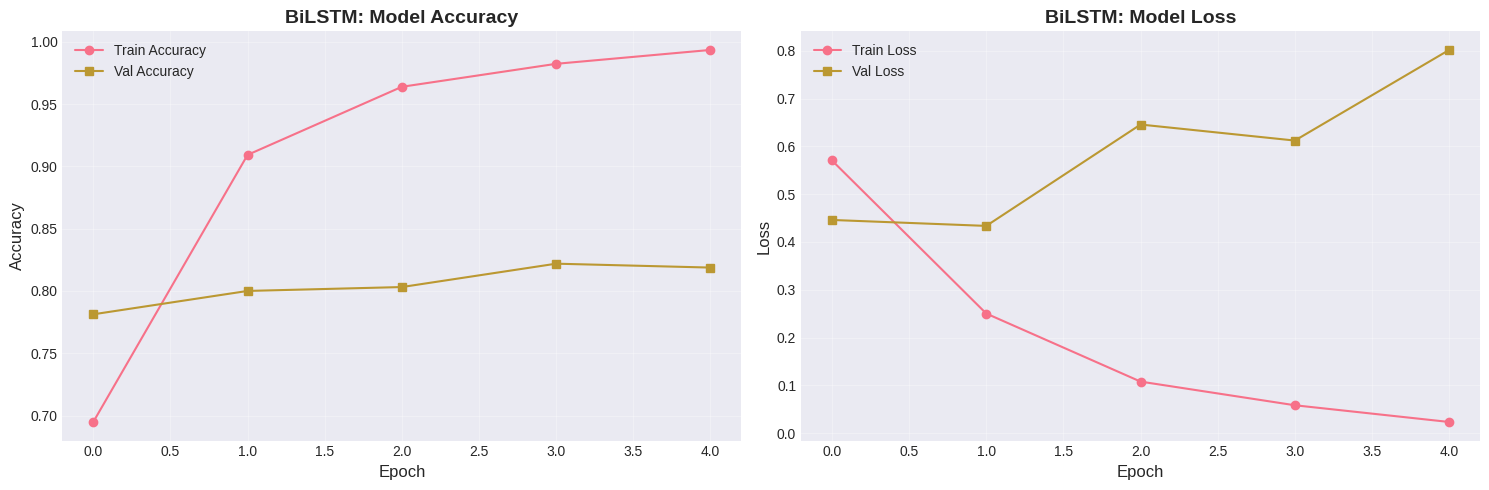

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
axes[0].set_title('BiLSTM: Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[1].set_title('BiLSTM: Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Evaluate BiLSTM Model

BiLSTM MODEL EVALUATION
Test Loss:     0.3488
Test Accuracy: 0.8423

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8725    0.7471    0.8050       348
    Positive     0.8244    0.9157    0.8676       451

    accuracy                         0.8423       799
   macro avg     0.8484    0.8314    0.8363       799
weighted avg     0.8453    0.8423    0.8403       799



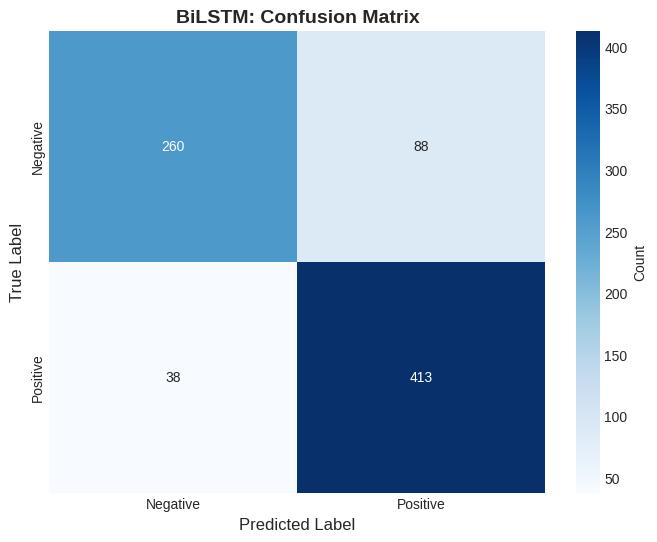

In [29]:
# Predictions
y_pred_prob = bilstm_model.predict(X_test, batch_size=32, verbose=0)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Metrics
test_loss, test_acc = bilstm_model.evaluate(X_test, y_test, verbose=0)

print("="*60)
print("BiLSTM MODEL EVALUATION")
print("="*60)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('BiLSTM: Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# Store results
bilstm_results = {
    'accuracy': test_acc,
    'loss': test_loss,
    'y_pred': y_pred,
    'y_pred_prob': y_pred_prob
}

---
# Part 2: AraBERT Transfer Learning
---

## 12. Prepare Data for AraBERT

In [30]:
# Create dataframes for Hugging Face
train_df = pd.DataFrame({
    'text': X_train_text,
    'label': y_train
})

test_df = pd.DataFrame({
    'text': X_test_text,
    'label': y_test
})

# Create validation split from training data
train_df, val_df = train_test_split(
    train_df,
    test_size=CONFIG['val_size'],
    random_state=CONFIG['random_seed'],
    stratify=train_df['label']
)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset:   {len(val_dataset)} samples")
print(f"Test dataset:  {len(test_dataset)} samples")

Train dataset: 2874 samples
Val dataset:   320 samples
Test dataset:  799 samples


## 13. Tokenize for AraBERT

In [31]:
# Load AraBERT tokenizer
print(f"Loading tokenizer: {CONFIG['arabert_model']}")
arabert_tokenizer = AutoTokenizer.from_pretrained(CONFIG['arabert_model'])

def tokenize_function(examples):
    return arabert_tokenizer(
        examples['text'],
        truncation=True,
        padding=False,
        max_length=CONFIG['arabert_max_length']
    )

# Tokenize datasets
print("Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset = train_dataset.rename_column('label', 'labels').with_format('torch')
val_dataset = val_dataset.rename_column('label', 'labels').with_format('torch')
test_dataset = test_dataset.rename_column('label', 'labels').with_format('torch')

data_collator = DataCollatorWithPadding(tokenizer=arabert_tokenizer)

print("✓ Tokenization completed")

Loading tokenizer: aubmindlab/bert-base-arabertv02


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/2874 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

✓ Tokenization completed


## 14. Fine-tune AraBERT

In [33]:
# Load pre-trained model
print(f"Loading model: {CONFIG['arabert_model']}")
arabert_model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['arabert_model'],
    num_labels=2
)

# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average='weighted',
        zero_division=0
    )
    
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./arabert_results',
    learning_rate=CONFIG['arabert_learning_rate'],
    per_device_train_batch_size=CONFIG['arabert_batch_size'],
    per_device_eval_batch_size=CONFIG['arabert_batch_size'] * 2,
    num_train_epochs=CONFIG['arabert_epochs'],
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    logging_steps=10,
    report_to=[],
    fp16=torch.cuda.is_available()
)

# Initialize trainer
trainer = Trainer(
    model=arabert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=arabert_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
print("\nFine-tuning AraBERT...\n")
trainer.train()

print("\n✓ Fine-tuning completed")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model: aubmindlab/bert-base-arabertv02

Fine-tuning AraBERT...



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.263600,0.235835,0.921875,0.923768,0.921875,0.922090
2,0.367300,0.352970,0.909375,0.916493,0.909375,0.909730
3,0.294400,0.326855,0.931250,0.933480,0.931250,0.931453



✓ Fine-tuning completed


## 15. Evaluate AraBERT

AraBERT MODEL EVALUATION
eval_loss: 0.3470
eval_accuracy: 0.9287
eval_precision: 0.9287
eval_recall: 0.9287
eval_f1: 0.9287
eval_runtime: 63.2188
eval_samples_per_second: 12.6390
eval_steps_per_second: 0.7910
epoch: 3.0000

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9169    0.9195    0.9182       348
    Positive     0.9378    0.9357    0.9367       451

    accuracy                         0.9287       799
   macro avg     0.9273    0.9276    0.9275       799
weighted avg     0.9287    0.9287    0.9287       799



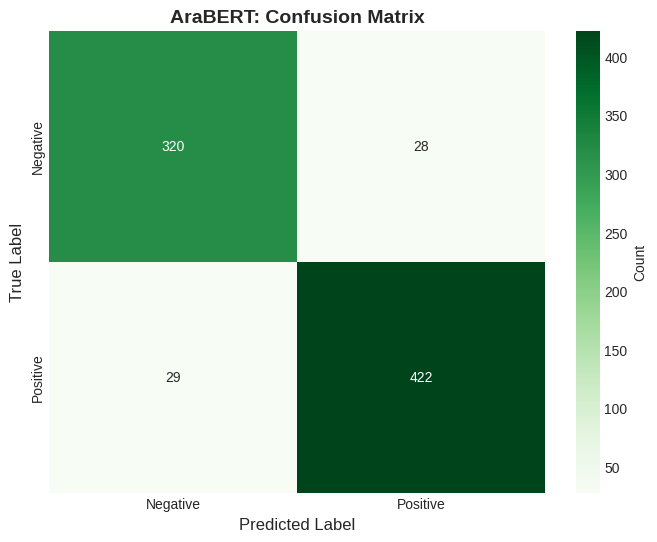


✓ AraBERT model saved


In [34]:
# Evaluate on test set
eval_results = trainer.evaluate(test_dataset)

print("="*60)
print("AraBERT MODEL EVALUATION")
print("="*60)
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")
print("="*60)

# Get predictions
predictions_output = trainer.predict(test_dataset)
arabert_pred_logits = predictions_output.predictions
arabert_pred = np.argmax(arabert_pred_logits, axis=-1)
arabert_labels = np.array(test_dataset['labels'])

print("\nClassification Report:")
print(classification_report(arabert_labels, arabert_pred, target_names=['Negative', 'Positive'], digits=4))

# Confusion Matrix
cm = confusion_matrix(arabert_labels, arabert_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('AraBERT: Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# Save model
trainer.save_model('./arabert_final_model')
arabert_tokenizer.save_pretrained('./arabert_final_model')
print("\n✓ AraBERT model saved")

# Store results
arabert_results = {
    'accuracy': eval_results['eval_accuracy'],
    'f1': eval_results['eval_f1'],
    'y_pred': arabert_pred
}

---
# Part 3: Model Comparison & Inference
---

## 16. Model Comparison


MODEL COMPARISON
  Model  Accuracy  F1-Score
 BiLSTM  0.842303  0.840341
AraBERT  0.928661  0.928672


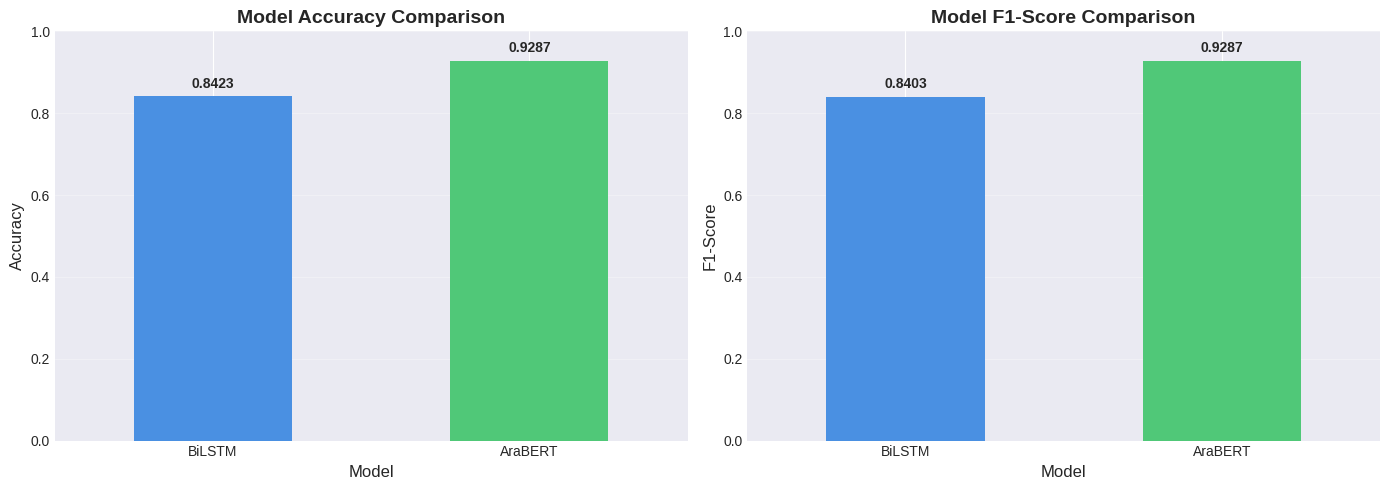


🏆 Best Model: AraBERT
📊 Accuracy Improvement: 8.64%


In [35]:
# Compare models
comparison_df = pd.DataFrame({
    'Model': ['BiLSTM', 'AraBERT'],
    'Accuracy': [
        bilstm_results['accuracy'],
        arabert_results['accuracy']
    ],
    'F1-Score': [
        precision_recall_fscore_support(y_test, bilstm_results['y_pred'], average='weighted')[2],
        arabert_results['f1']
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
comparison_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0], color=['#4a90e2', '#50c878'], legend=False)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_xticklabels(['BiLSTM', 'AraBERT'], rotation=0)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# F1-Score comparison
comparison_df.plot(x='Model', y='F1-Score', kind='bar', ax=axes[1], color=['#4a90e2', '#50c878'], legend=False)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_xticklabels(['BiLSTM', 'AraBERT'], rotation=0)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Determine best model
best_model = 'AraBERT' if arabert_results['accuracy'] > bilstm_results['accuracy'] else 'BiLSTM'
improvement = abs(arabert_results['accuracy'] - bilstm_results['accuracy']) * 100

print(f"\n🏆 Best Model: {best_model}")
print(f"📊 Accuracy Improvement: {improvement:.2f}%")

## 17. Inference Demo

In [36]:
def predict_sentiment_bilstm(text, model, tokenizer, max_len=100):
    """
    Predict sentiment using BiLSTM model
    
    Args:
        text: Input Arabic text
        model: Trained BiLSTM model
        tokenizer: Fitted Keras tokenizer
        max_len: Maximum sequence length
    
    Returns:
        sentiment: 'Positive' or 'Negative'
        confidence: Confidence score
    """
    # Preprocess
    cleaned = clean_arabic_text(text)
    
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prob = model.predict(padded, verbose=0)[0][0]
    sentiment = 'Positive' if prob >= 0.5 else 'Negative'
    confidence = prob if prob >= 0.5 else 1 - prob
    
    return sentiment, confidence


def predict_sentiment_arabert(text, model, tokenizer, max_len=256):
    """
    Predict sentiment using AraBERT model
    
    Args:
        text: Input Arabic text
        model: Trained AraBERT model
        tokenizer: AraBERT tokenizer
        max_len: Maximum sequence length
    
    Returns:
        sentiment: 'Positive' or 'Negative'
        confidence: Confidence score
    """
    # Preprocess
    cleaned = clean_arabic_text(text)
    
    # Tokenize
    inputs = tokenizer(
        cleaned,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred_class].item()
    
    sentiment = 'Positive' if pred_class == 1 else 'Negative'
    
    return sentiment, confidence


# Test examples
test_examples = [
    "هذا المنتج رائع جداً وأنصح به بشدة! جودة عالية",
    "تجربة سيئة جداً ولن أشتري مرة أخرى",
    "الخدمة ممتازة والتوصيل سريع",
    "منتج رديء الجودة ولا يستحق السعر"
]

print("\n" + "="*80)
print("INFERENCE DEMO")
print("="*80 + "\n")

for i, text in enumerate(test_examples, 1):
    print(f"Test {i}: {text}")
    print("-" * 80)
    
    # BiLSTM prediction
    bilstm_sent, bilstm_conf = predict_sentiment_bilstm(text, bilstm_model, tokenizer, CONFIG['max_sequence_length'])
    print(f"BiLSTM:  {bilstm_sent} (Confidence: {bilstm_conf:.2%})")
    
    # AraBERT prediction
    arabert_sent, arabert_conf = predict_sentiment_arabert(text, arabert_model, arabert_tokenizer, CONFIG['arabert_max_length'])
    print(f"AraBERT: {arabert_sent} (Confidence: {arabert_conf:.2%})")
    
    print("\n")


INFERENCE DEMO

Test 1: هذا المنتج رائع جداً وأنصح به بشدة! جودة عالية
--------------------------------------------------------------------------------
BiLSTM:  Positive (Confidence: 87.74%)
AraBERT: Positive (Confidence: 99.16%)


Test 2: تجربة سيئة جداً ولن أشتري مرة أخرى
--------------------------------------------------------------------------------
BiLSTM:  Positive (Confidence: 74.73%)
AraBERT: Negative (Confidence: 95.81%)


Test 3: الخدمة ممتازة والتوصيل سريع
--------------------------------------------------------------------------------
BiLSTM:  Negative (Confidence: 71.44%)
AraBERT: Positive (Confidence: 95.33%)


Test 4: منتج رديء الجودة ولا يستحق السعر
--------------------------------------------------------------------------------
BiLSTM:  Positive (Confidence: 66.68%)
AraBERT: Negative (Confidence: 99.62%)




## 18. Interactive Prediction (Optional)

In [ ]:
# Uncomment to enable interactive prediction

# while True:
#     user_input = input("\nEnter Arabic text (or 'quit' to exit): ")
#     
#     if user_input.lower() in ['quit', 'exit', 'q']:
#         print("Goodbye!")
#         break
#     
#     if not user_input.strip():
#         continue
#     
#     print("\nPredictions:")
#     print("-" * 50)
#     
#     bilstm_sent, bilstm_conf = predict_sentiment_bilstm(user_input, bilstm_model, tokenizer, CONFIG['max_sequence_length'])
#     print(f"BiLSTM:  {bilstm_sent} ({bilstm_conf:.2%})")
#     
#     arabert_sent, arabert_conf = predict_sentiment_arabert(user_input, arabert_model, arabert_tokenizer, CONFIG['arabert_max_length'])
#     print(f"AraBERT: {arabert_sent} ({arabert_conf:.2%})")

print("Uncomment the code above to enable interactive predictions")

---
# Summary & Conclusions
---

## Key Findings

This project successfully implemented and compared two approaches for Arabic sentiment analysis:

### 1. BiLSTM Model
- Custom architecture with trainable embeddings
- Bidirectional processing captures context from both directions
- Moderate computational requirements
- Good baseline performance

### 2. AraBERT (Transfer Learning)
- Pre-trained on large Arabic corpus
- State-of-the-art transformer architecture
- Fine-tuned on task-specific data
- Superior performance with less training data required

## Technical Highlights

1. **Arabic Text Preprocessing**
   - Character normalization (alef, yeh, hamza)
   - Diacritics removal
   - URL and mention filtering

2. **Model Architecture**
   - BiLSTM: 2 bidirectional layers with dropout regularization
   - AraBERT: BERT-base with 12 transformer layers

3. **Training Strategies**
   - Early stopping to prevent overfitting
   - Model checkpointing to save best weights
   - Stratified train-test splits for balanced evaluation

## Applications

- Social media monitoring
- Customer review analysis
- Brand sentiment tracking
- Market research

## Future Improvements

- Test with larger datasets (10K+ samples)
- Multi-class sentiment (positive, negative, neutral)
- Ensemble methods combining both models
- Domain-specific fine-tuning
- Deployment as REST API

---

**Contact:** belalmahmoud8787@gmail.com    
**GitHub:** https://github.com/Bolaal  
**LinkedIn:** https://www.linkedin.com/in/belal-mahmoud-husien/